<a href="https://colab.research.google.com/github/chaitykundu/3D-Insole-Prediction/blob/main/Convert2Dto3DInsole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
!pip install trimesh pythreejs


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 271.7/271.7 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 65.5 MB/s eta 0:00:00


In [1]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
from shapely.geometry import Polygon
from shapely.ops import unary_union

#Load Image()

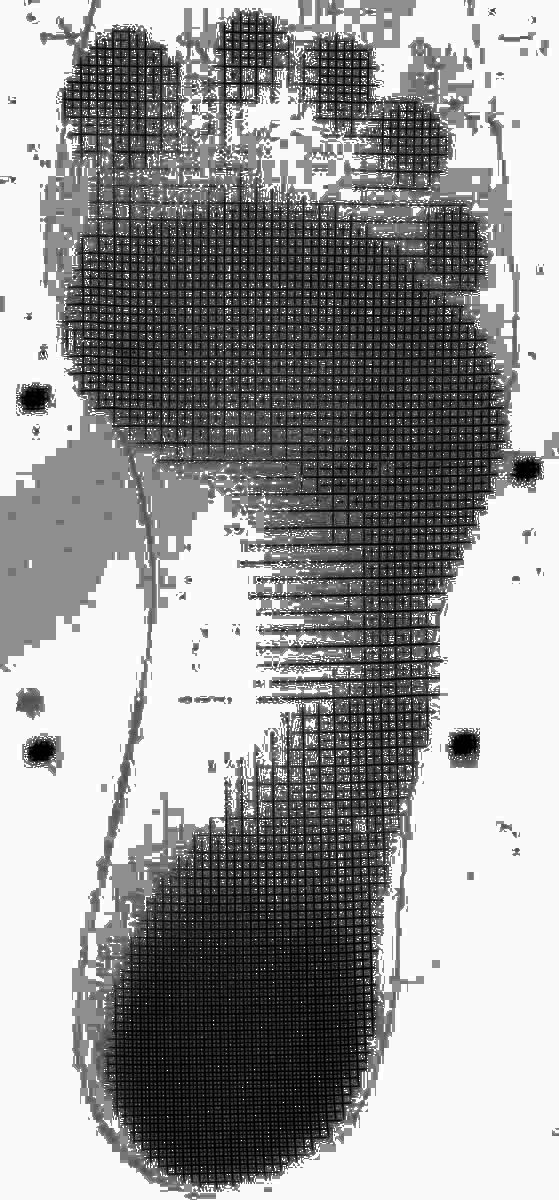

-1

In [2]:
# Load
img = cv2.imread("/content/podographic print.jpg")

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Normalize brightness a little
gray = cv2.equalizeHist(gray)

cv2_imshow(gray)
cv2.waitKey(0)


#Remove the Background Grid

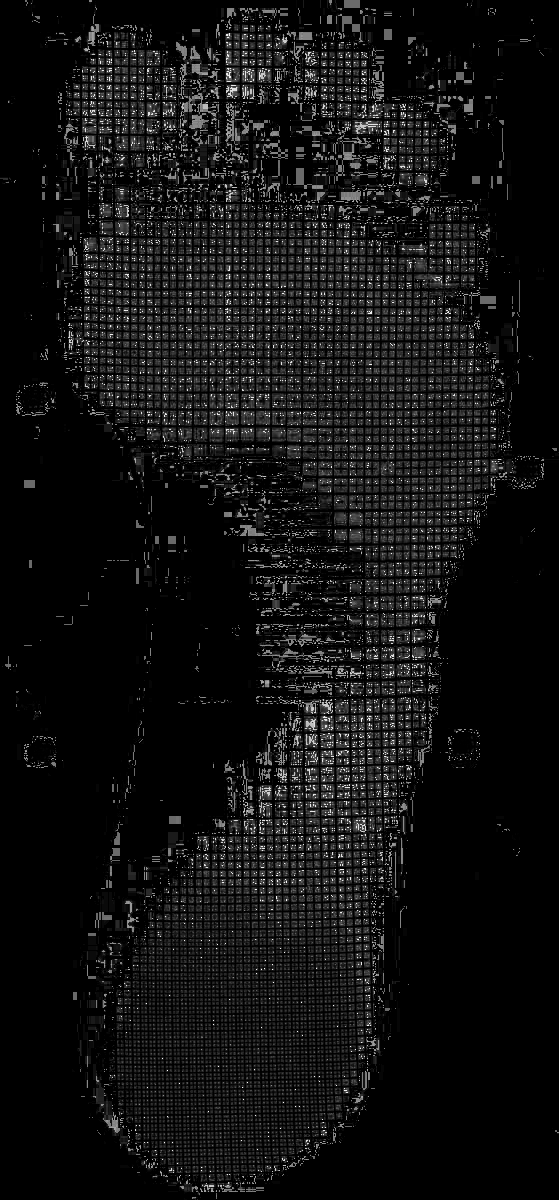

In [3]:
# Extract horizontal lines
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1))
remove_horizontal = cv2.morphologyEx(gray, cv2.MORPH_OPEN, horizontal_kernel)

# Extract vertical lines
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 40))
remove_vertical = cv2.morphologyEx(gray, cv2.MORPH_OPEN, vertical_kernel)

# Combine
grid_mask = cv2.bitwise_or(remove_horizontal, remove_vertical)

# Subtract from original
foot_no_grid = cv2.subtract(gray, grid_mask)

cv2_imshow( foot_no_grid)


# Remove calibration dots

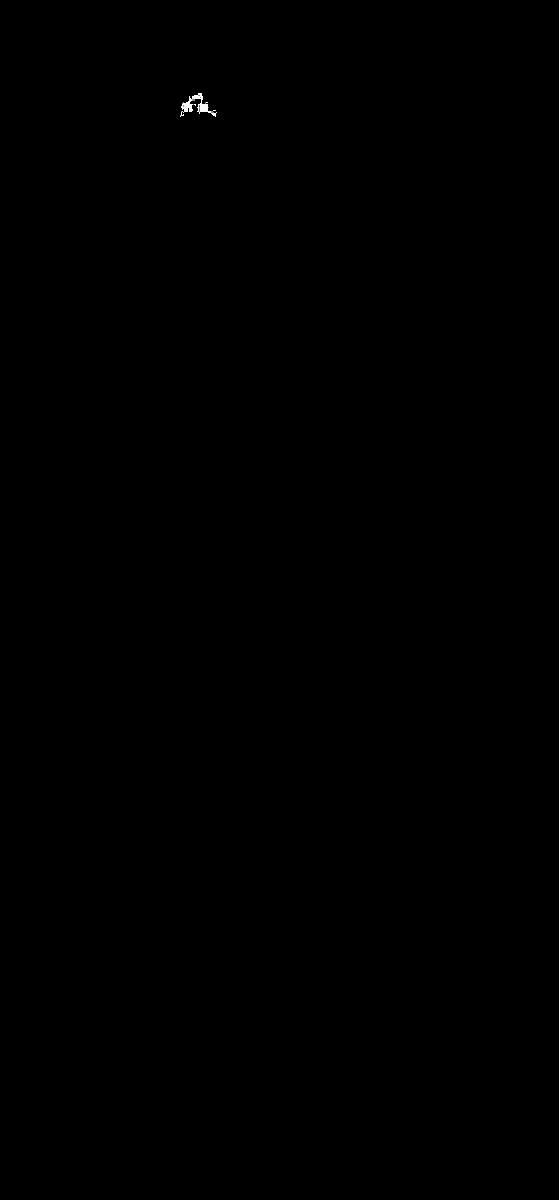

In [4]:
# Threshold image
_, th = cv2.threshold(foot_no_grid, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Find contours
cnts, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Keep only large contour (the foot)
foot_cnt = max(cnts, key=cv2.contourArea)

# Create mask containing ONLY the foot
mask = np.zeros_like(gray)
cv2.drawContours(mask, [foot_cnt], -1, 255, -1)

clean_foot = cv2.bitwise_and(gray, gray, mask=mask)

cv2_imshow(clean_foot)


# Extract the Foot Shape

In [13]:
# Threshold again
_, th2 = cv2.threshold(clean_foot, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Detect contour
cnts, _ = cv2.findContours(th2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
foot_contour = max(cnts, key=cv2.contourArea)
print(foot_contour)

[[[198  93]]

 [[198  94]]

 [[197  95]]

 [[194  95]]

 [[193  96]]

 [[192  96]]

 [[192  98]]

 [[191  99]]

 [[189  97]]

 [[189  96]]

 [[189 100]]

 [[187 102]]

 [[186 102]]

 [[185 103]]

 [[184 103]]

 [[183 102]]

 [[182 103]]

 [[182 105]]

 [[181 106]]

 [[181 107]]

 [[182 108]]

 [[182 109]]

 [[183 108]]

 [[184 109]]

 [[184 111]]

 [[183 112]]

 [[182 111]]

 [[181 111]]

 [[181 114]]

 [[180 115]]

 [[180 116]]

 [[181 115]]

 [[183 115]]

 [[183 114]]

 [[182 115]]

 [[181 114]]

 [[181 112]]

 [[182 111]]

 [[183 112]]

 [[184 111]]

 [[187 111]]

 [[187 108]]

 [[188 107]]

 [[189 108]]

 [[189 111]]

 [[191 111]]

 [[192 110]]

 [[192 109]]

 [[191 108]]

 [[191 105]]

 [[192 104]]

 [[190 104]]

 [[189 103]]

 [[189 102]]

 [[191 100]]

 [[194 100]]

 [[194  99]]

 [[195  98]]

 [[200  98]]

 [[201  99]]

 [[201 102]]

 [[199 104]]

 [[198 104]]

 [[198 106]]

 [[197 107]]

 [[198 108]]

 [[198 110]]

 [[197 111]]

 [[198 111]]

 [[199 112]]

 [[199 113]]

 [[199

#Convert Pixels → Millimeters


In [14]:
# pick a known grid spacing (say 5mm) from the print
# find 2 vertical grid lines by Hough transform

lines = cv2.HoughLinesP(gray, 1, np.pi/180, threshold=150, minLineLength=100, maxLineGap=10)

# measure distance between two parallel vertical lines
dist_px = abs(lines[0][0][0] - lines[1][0][0])  # x1 - x2

mm_per_pixel = 5.0 / dist_px
print(mm_per_pixel)


0.06172839506172839


#Compute Measurements(Foot- length, width, heel)

In [15]:
ys = foot_contour[:,0,1]
foot_length_mm = (ys.max() - ys.min()) * mm_per_pixel
print(foot_length_mm)

1.419753086419753


In [16]:
xs = foot_contour[:,0,0]
foot_width_mm = (xs.max() - xs.min()) * mm_per_pixel
print(foot_width_mm)


2.2222222222222223


In [19]:
# crop lowest 20% of foot
heel_region = ys.max() - 0.2*(ys.max()-ys.min())
heel_mask = (foot_contour[:,0,1] > heel_region)
heel_width_mm = (foot_contour[heel_mask][:,0,0].max() - foot_contour[heel_mask][:,0,0].min()) * mm_per_pixel
print(heel_region)
print(heel_mask)
print(heel_width_mm)

111.4
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False  True False False  True  True  True  True  True  True  True  True
  True False  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False  True  True  True
 False False  True  True  True  True  True  True  True  True  True False
 False False False False False False False False False False False False
 False False False False False False False False]
2.2222222222222223


#orientation_detection() (PCA)

In [20]:
# count white pixels in the midfoot
mid_y1 = ys.min() + 0.4*(ys.max()-ys.min())
mid_y2 = ys.min() + 0.6*(ys.max()-ys.min())

midfoot = clean_foot[int(mid_y1):int(mid_y2), :]
white_ratio = np.mean(midfoot > 200)

if white_ratio < 0.20:
    arch_type = "high"
elif white_ratio < 0.45:
    arch_type = "normal"
else:
    arch_type = "flat"

print("White pixel ratio in midfoot:", white_ratio)
print("Detected Arch Type:", arch_type)


White pixel ratio in midfoot: 0.0259391771019678
Detected Arch Type: high


#Build Pressure Map

In [43]:
foot_float = clean_foot.astype(np.float32)
pressure_map = 1.0 - (foot_float / foot_float.max())

# optionally smooth it
#pressure_map = cv2.GaussianBlur(pressure_map, (9,9), 0)
print(pressure_map)


[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


In [44]:
H, W = clean_foot.shape

height_map = np.zeros((H, W), dtype=np.float32)

for i in range(H):
    for j in range(W):
        if clean_foot[i,j] == 0:
            continue

        base = 3.0  # mm
        arch = compute_arch_bump(i,j, height_map, foot_length_mm, foot_width_mm, arch_type)
        heel = compute_heel_cup(i,j, foot_length_mm)
        pressure = pressure_map[i,j] * 3.0

        height_map[i,j] = base + arch + heel + pressure

        print(height_map)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

In [59]:
import numpy as np
import trimesh

# Step 1: Build Mesh Grid (Vertices) for the top surface
H, W = clean_foot.shape
top_vertices = []
# Create a map from (grid_i, grid_j) to the actual index in the 'top_vertices' list
vertex_map = np.full((H, W), -1, dtype=int) # Initialize with -1 for non-foot pixels

XX, YY = np.meshgrid(np.arange(0, W), np.arange(0, H))  # Pixel indices
XX_mm = XX * mm_per_pixel
YY_mm = YY * mm_per_pixel

current_vertex_idx = 0
for i in range(H):
    for j in range(W):
        if clean_foot[i, j] != 0:  # Only add vertices for foot regions
            z = height_map[i, j]
            top_vertices.append([XX_mm[i, j], YY_mm[i, j], z])
            vertex_map[i, j] = current_vertex_idx # Store the actual index
            current_vertex_idx += 1

# Convert to numpy array for trimesh
top_vertices = np.array(top_vertices)

# Create bottom_vertices by setting Z = 0 for the top_vertices
bottom_vertices = top_vertices.copy()
bottom_vertices[:, 2] = 0.0  # Set Z to 0 for bottom surface

# Combine top and bottom vertices into a single array
vertices = np.vstack((top_vertices, bottom_vertices))

print(vertices)

[[12.22222222  5.74074074  5.78168964]
 [12.28395062  5.74074074  5.71110106]
 [12.34567901  5.74074074  5.78168964]
 ...
 [13.27160494  7.09876543  0.        ]
 [11.11111111  7.16049383  0.        ]
 [13.27160494  7.16049383  0.        ]]


#Create Bottom Surface (Flat at Z=0)

In [61]:
# Generate faces (top, bottom, and side faces)
faces = []
num_top_vertices = len(top_vertices) # Number of vertices in the top surface

for i in range(H - 1):
    for j in range(W - 1):
        # Check if all four corners of the quad are part of the foot
        # This is crucial to avoid creating faces on non-foot regions
        if (vertex_map[i, j] != -1 and
            vertex_map[i, j+1] != -1 and
            vertex_map[i+1, j] != -1 and
            vertex_map[i+1, j+1] != -1):

            # Get the actual indices for the top vertices from the map
            v0_top = vertex_map[i, j]
            v1_top = vertex_map[i, j+1]
            v2_top = vertex_map[i+1, j]
            v3_top = vertex_map[i+1, j+1]

            # Get the corresponding indices for the bottom vertices
            # These are offset by num_top_vertices in the combined 'vertices' array
            v0_bottom = v0_top + num_top_vertices
            v1_bottom = v1_top + num_top_vertices
            v2_bottom = v2_top + num_top_vertices
            v3_bottom = v3_top + num_top_vertices

            # Top surface faces (2 triangles)
            faces.append([v0_top, v1_top, v2_top])
            faces.append([v1_top, v3_top, v2_top]) # Ensure consistent winding

            # Bottom surface faces (2 triangles - reverse winding from top)
            faces.append([v0_bottom, v2_bottom, v1_bottom])
            faces.append([v1_bottom, v2_bottom, v3_bottom]) # Ensure consistent winding

            # Side walls (4 quads, each 2 triangles)
            # Edge (i,j) to (i,j+1)
            faces.append([v0_top, v0_bottom, v1_bottom])
            faces.append([v0_top, v1_bottom, v1_top])

            # Edge (i,j+1) to (i+1,j+1)
            faces.append([v1_top, v1_bottom, v3_bottom])
            faces.append([v1_top, v3_bottom, v3_top])

            # Edge (i+1,j+1) to (i+1,j)
            faces.append([v3_top, v3_bottom, v2_bottom])
            faces.append([v3_top, v2_bottom, v2_top])

            # Edge (i+1,j) to (i,j)
            faces.append([v2_top, v2_bottom, v0_bottom])
            faces.append([v2_top, v0_bottom, v0_top])

# Convert faces into numpy array
faces = np.array(faces)
print(faces)

[[  0   1   4]
 [  1   5   4]
 [297 301 298]
 ...
 [294 590 293]
 [293 590 583]
 [293 583 286]]


In [62]:
import trimesh

# Create a Trimesh object
mesh = trimesh.Trimesh(vertices=vertices, faces=faces)

# Export to STL file
mesh.export('insole.stl')

b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00p\x08\x00\x00\x1ad>?:Z\x1e\xbeM~&?9\x8eCA&\xb4\xb7@\x9a\x03\xb9@\x10\x8bDA&\xb4\xb7@W\xc1\xb6@9\x8eCA\xd4\xad\xb9@\xd7{\xb9@\x00\x00\xeac>?\xa9[\x1e\xben~&?\x10\x8bDA&\xb4\xb7@W\xc1\xb6@\x10\x8bDA\xd4\xad\xb9@\x959\xb7@9\x8eCA\xd4\xad\xb9@\xd7{\xb9@\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xbf9\x8eCA&\xb4\xb7@\x00\x00\x00\x009\x8eCA\xd4\xad\xb9@\x00\x00\x00\x00\x10\x8bDA&\xb4\xb7@\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xbf\x10\x8bDA&\xb4\xb7@\x00\x00\x00\x009\x8eCA\xd4\xad\xb9@\x00\x00\x00\x00\x10\x8bDA\xd4\xad\xb9@\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xbf\x00\x00\x00\x009\x8eCA&\xb4\xb7@\x9a\x03\xb9@9\x8eCA&\xb4\xb

In [70]:
import trimesh
from pythreejs import *
from IPython.display import display

# Load the STL file
mesh = trimesh.load_mesh('/content/insole.stl')

# Ensure the mesh vertices and faces are of the correct type (float64)
vertices = mesh.vertices.astype('float64')  # Ensure float64 for pythreejs
faces = mesh.faces.astype('int32')          # Faces indices should be int32

# Convert the vertices and faces into the required format for pythreejs
geometry = Geometry(
    attributes={'position': BufferAttribute(vertices, normalized=False)},
    index=BufferAttribute(faces, normalized=False)
)

# Visualize it using pythreejs
scene = Scene(children=[
    AmbientLight(intensity=0.5),
    DirectionalLight(position=[3, 5, 1], intensity=0.8),
    Mesh(geometry=geometry, material=MeshStandardMaterial(color='lightblue'))
])

# Camera
camera = PerspectiveCamera(position=[3, 3, 3], fov=50, aspect=1, near=0.1, far=10)
controller = OrbitControls(controlling=camera)

# Render
renderer = WebGLRenderer(camera=camera, scene=scene, width=600, height=400)
display(renderer)


/usr/local/lib/python3.12/dist-packages/traittypes/traittypes.py:98: UserWarning: Given trait value dtype "float64" does not match required type "float64". A coerced copy has been created.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pythreejs/traits.py:257: UserWarning: 64-bit data types not supported for WebGL data, casting to 32-bit.
  warnings.warn('64-bit data types not supported for WebGL '
/usr/local/lib/python3.12/dist-packages/traittypes/traittypes.py:98: UserWarning: Given trait value dtype "int32" does not match required type "float64". A coerced copy has been created.
  warnings.warn(


WebGLRenderer(shadowMap=WebGLShadowMap())